I made a modification to TPCF that seems to have some issues... debugging it compared to the halotools one. 

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import matplotlib.colors as colors

In [2]:
import numpy as np
from glob import glob
from os import path

In [3]:
from pearce.mocks.kittens import DarkSky
from pearce.mocks import tpcf as pearce_tpcf
from halotools.mock_observables import tpcf as halotools_tpcf
from halotools.empirical_models import Zheng07Cens, Zheng07Sats
from collections import OrderedDict
from time import time
from scipy.optimize import minimize_scalar
import yaml

In [4]:
output_dir = '/home/users/swmclau2/Git/pearce/bin/covmat/ds14_covmat/'

In [5]:
config_fname = 'xi_cosmo_trainer.yaml'

with open(path.join(output_dir, config_fname), 'r') as ymlfile:
    cfg = yaml.load(ymlfile)

nd = float(cfg['HOD']['fixed_nd'] )
min_ptcl = int(cfg['HOD']['min_ptcl'])
r_bins = np.array(cfg['observation']['bins'] ).astype(float)

hod_param_ranges =  cfg['HOD']['ordered_params']


logMmin_bounds = hod_param_ranges['logMmin']


del hod_param_ranges['logMmin']

In [6]:
def make_LHC(ordered_params, N, seed = None):

    if seed is None:
        seed = int(time())
    np.random.seed(seed)

    points = []
    # by linspacing each parameter and shuffling, I ensure there is only one point in each row, in each dimension.
    for plow, phigh in ordered_params.itervalues():
        point = np.linspace(plow, phigh, num=N)
        np.random.shuffle(point)  # makes the cube random.
        points.append(point)
    return np.stack(points).T


def add_logMmin(hod_params, cat):

    hod_params['logMmin'] = 13.0 #initial guess
    #cat.populate(hod_params) #may be overkill, but will ensure params are written everywhere
    def func(logMmin, hod_params):
        hod_params.update({'logMmin':logMmin})
        return (cat.calc_analytic_nd(hod_params, min_ptcl = min_ptcl) - nd)**2

    res = minimize_scalar(func, bounds = logMmin_bounds, args = (hod_params,), options = {'maxiter':100}, method = 'Bounded')

    # assuming this doens't fail
    #print 'logMmin', res.x
    hod_params['logMmin'] = res.x

In [7]:
from pearce.mocks.kittens import TestBox
cat = TestBox(boxno = 0, realization = 0, system = 'sherlock')
cat.load(1.0, HOD='zheng07')

In [8]:
# TODO seed here for constant HODs
# TODO maybe just do 5, 10 may be overkill
N = 10
LHC = make_LHC(hod_param_ranges, N, 24)
hod_dicts = [dict(zip(hod_param_ranges.keys(), vals)) for vals in LHC]

In [9]:
cat.populate(hod_dicts[0])

In [10]:
n_cores = 2# cat._check_cores(4)#16)

x_g, y_g, z_g = [cat.model.mock.galaxy_table[c] for c in ['x', 'y', 'z']]
pos_g = np.vstack([x_g, y_g, z_g]).T

r_bins = np.array(r_bins)
randoms = np.random.random((pos_g.shape[0]*10, 3))*cat.Lbox/cat.h


pearce_xi = pearce_tpcf(pos_g / cat.h, r_bins, randoms = randoms,
                      num_threads=n_cores, estimator='Landy-Szalay',\
                      do_auto1 = True, do_cross = False, n_split = 1)#, RR_precomputed=RR, NR_precomputed=randoms.shape[0])#, do_auto2 = False)

halotools_xi = halotools_tpcf(pos_g / cat.h, r_bins, randoms = randoms,
                      num_threads=n_cores, estimator='Landy-Szalay',\
                      do_auto = True, do_cross = False)#, RR_precomputed=RR, NR_precomputed=randoms.shape[0])#, do_auto2 = False)


[]

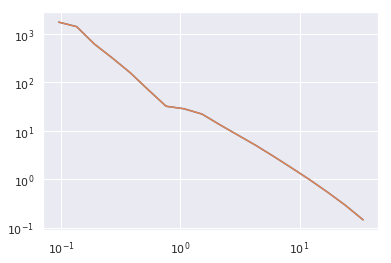

In [11]:
rpoints = (r_bins[1:] + r_bins[:-1])/2.0
plt.plot(rpoints, pearce_xi.squeeze())
plt.plot(rpoints, halotools_xi.squeeze())
plt.loglog()

In [12]:
pearce_xi/halotools_xi

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.])